In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import yaml

from scipy import stats

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
recall_score, log_loss
from sklearn.preprocessing import label_binarize

import lightgbm
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier

from typing import Union, Any

import pickle
import json

import import_ipynb
from nlp_modeling_3 import to_pickle

import warnings
warnings.filterwarnings("ignore")

# 1. Выгрузка и преобразование данных

Выгружу данные, понижу размерность фичей и разобью на трейновую, тестовую и валидационные выборки

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [3]:
train_df_path = config['nlp_modeling']['train_df']

In [4]:
def from_csv(path: str) -> pd.DataFrame:
    """
    Загрузка таблицы из пути
    :params path: путь до файла
    :return: пандас таблица
    """
    return pd.read_csv(path)

In [5]:
train_df = from_csv(train_df_path)

In [6]:
def X_y_separator(df: pd.DataFrame, target: str) -> (pd.DataFrame, np.ndarray):
    """
    Разделение данных на признаки и таргет
    :params df: таблица, которую надо разделить
    :params target: имя колонки, которая является целевой
    :return: Таблица объектов-признаков
    :return: вектор ответов
    """
    return df.drop([target], axis=1), df[target]

In [7]:
X, y = X_y_separator(train_df, 'target')

In [8]:
def replace_negative_class(data: np.ndarray) -> np.ndarray:
    """
    Замена класса -1 на положительное число (максимальная метка класса + 1)
    :data: массив, в котором нужно заменить -1
    :return: исправленный массив
    """
    data[data == -1] = data.max() + 1
    return data

In [9]:
y = replace_negative_class(y)

In [10]:
rs = config['train_ml']['random_state']
n_components = config['train_ml']['n_compoments_for_pca']

In [11]:
def pca_fit_transform(data: Union[pd.DataFrame, np.ndarray],
                      n_components: Union[int, float],
                      random_state: int
    ) -> (sklearn.decomposition._pca.PCA, np.ndarray):
    """
    Понижение размерности данных
    :params data: массив данных, размерность которого нужно понизить
    :params n_components: до какого количества признаков понизить размер,
                          либо доля обоснованной дисперсии
    :params random_state: рандом стейт
    :return: модель pca (нужна будет в ноутбуке evaluate)
    :return: итоговый массив после понижения размерности
    """
    pca = PCA(n_components=n_components, random_state=random_state)
    return pca, pca.fit_transform(data)


In [12]:
pca_model, X_emb = pca_fit_transform(X, n_components, rs)

In [13]:
def train_test_val_split(X: np.ndarray, 
                         y: np.ndarray, 
                         test_size: float, 
                         val_size: float, 
                         random_state: int
    ) -> (np.ndarray, np.ndarray, np.ndarray, 
          np.ndarray, np.ndarray, np.ndarray,):
    """
    Деление на трейновую, тестовую и валидационную выборки
    :params X: массив объектов-признаков
    :params y: вектор ответов
    :params test_size: доля тестовой выборки
    :params val_size: доля валидационной выборки
    :params random_state: рандом стейт
    :return: X и y трейновой, тестовой и валидационной выборок
    """
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=y)

    X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                        y_train,
                                                        test_size=val_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                        stratify=y_train)
    
    return X_train_, y_train_, X_val, y_val, X_test, y_test

In [14]:
test_size = config['train_ml']['test_size']
val_size = config['train_ml']['val_size']

In [15]:
X_train_, y_train_, X_val, y_val, X_test, y_test = train_test_val_split(X_emb,
                                                                        y,
                                                                        test_size,
                                                                        val_size,
                                                                        rs)

In [16]:
def label_binarization(data: np.ndarray) -> np.ndarray:
    """
    Бинаризация меток классов из вектора ответов 
    :params data: вектор ответов
    :return: массив бинаризованных меток
    """
    return label_binarize(data, classes=list(set(data)))

In [17]:
y_test_bin = label_binarization(y_test)

In [18]:
y_train_bin = label_binarization(y_train_)

In [19]:
def draw_distribution_of_target(data: pd.Series, name: str, title: str) -> None:
    """
    Отрисовка распределения таргета с выводом процентов над каждым баром
    :params data: столбец с таргетом
    :params name: наименование колонки с таргетом
    :params title: название графика
    """
    df_segm_percent = data.value_counts(
        normalize=True).mul(100).rename('percent').reset_index()

    ax = plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_segm_percent, x=name, y='percent', color='green')

    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 4),
                    textcoords='offset points')

    ax.set_title(title)
    plt.show()

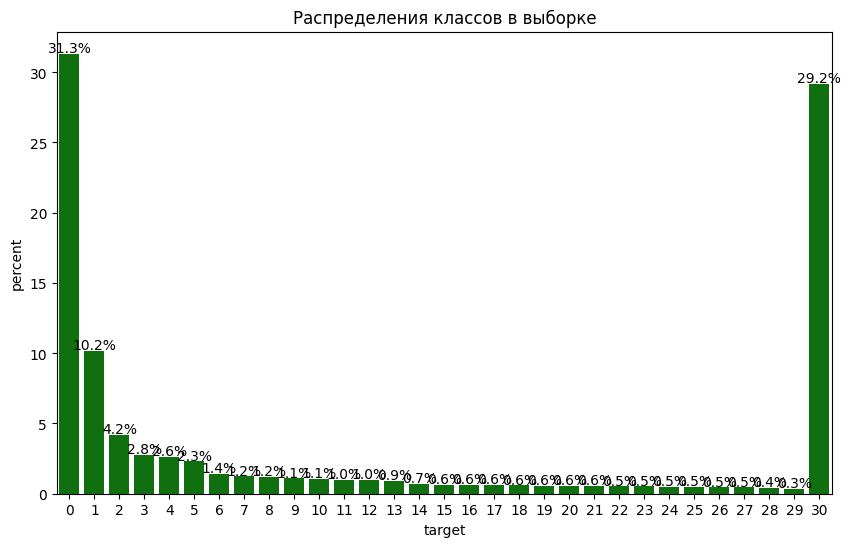

In [20]:
draw_distribution_of_target(y, 'target', 'Распределения классов в выборке')

Видно, что классы распределены очень неравномерно. Ососбенно выделяются мусорные комментарии (класс 30) и 0 класс.

# 2. Построение бейзлайнов

## 2.1 LGBM бейзлайн

Построим бейзлайн модель lgbm и выведем получившиеся метрики

In [21]:
def lgbm_fit(X_train: np.ndarray, y_train: np.ndarray,
             X_val: np.ndarray, y_val: np.ndarray, random_state: int, **params
             ) -> lightgbm.sklearn.LGBMClassifier:
    """
    Обучение LGBMClassifier с введенными параметрами 
    для многоклассовой класификации
    :params X_train: обучающая выборка
    :params y_train: ответы обучающей выборки
    :params X_val: валидационная выборка
    :params y_val: ответы валидационной выборки
    :params random_state: рандом стейт
    :params params: дополнительные параметры модели
    :return: обучанная модель
    """
    if params:
        lgbm_clf = LGBMClassifier(params,
                                  objective='multiclass',
                                  class_weight='balanced',
                                  eval_metric='auc',
                                  random_state=random_state,
                                  verbose=-1)
    else:
        lgbm_clf = LGBMClassifier(objective='multiclass',
                                  class_weight='balanced',
                                  random_state=random_state,
                                  verbose=-1)

    eval_set = [(X_val, y_val)]

    lgbm_clf.fit(X_train,
                 y_train,
                 eval_set=eval_set)
    return lgbm_clf


In [20]:
lgbm_clf_base = lgbm_fit(X_train_, y_train_, X_val, y_val, rs)

In [19]:
def get_metrics_multiclass(y_test_bin, y_test, y_pred, y_prob, name,
                           type_multi):
    """
    y_test_bin - бинаризованные тестовые метки класса
    y_test - метки класса без бинаризации
    y_prob - предсказанные вероятности классов
    name - название модели/подхода
    type_multi - тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """

    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin,
                                          y_prob,
                                          multi_class=type_multi)
    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')
    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')
    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

In [20]:
def check_overfitting(y_pred_proba_train: np.ndarray, 
                      y_train_bin: np.ndarray, 
                      y_pred_proba_test: np.ndarray, 
                      y_test_bin: np.ndarray, 
                      type_multi: str
    ) -> None:
    """
    Проверка на overfitting для многоклассовой классификации
    :params y_pred_proba_train: массив предсказаний вероятностей трейновой выборки
    :params y_train_bin: бинаризованный массив ответов трейновой выборки
    :params y_pred_proba_test: массив предсказаний вероятностей тестовой выборки
    :params y_test_bin: бинаризованный массив ответов тестовой выборки
    :params type_multi: стратегия мнокоглассовой классификации
    """
    value_train = roc_auc_score(y_train_bin, y_pred_proba_train, 
                                multi_class=type_multi)
    value_test = roc_auc_score(y_test_bin, y_pred_proba_test, 
                               multi_class=type_multi)

    print(f'roc_auc train: %.3f' % value_train)
    print(f'roc_auc test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [184]:
y_pred_test_lgbm_base = lgbm_clf_base.predict(X_test)
y_pred_proba_test_lgbm_base = lgbm_clf_base.predict_proba(X_test)

y_pred_proba_train_lgbm_base = lgbm_clf_base.predict_proba(X_train_)

In [185]:
get_metrics_multiclass(y_test_bin, y_test, y_pred_test_lgbm_base,
                       y_pred_proba_test_lgbm_base, 'lgbm_base', 'ovo')

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,lgbm_base,0.992732,0.820972,0.870934,0.820972,0.808104,0.820972,0.836352,0.551806


In [186]:
check_overfitting(y_pred_proba_train_lgbm_base, y_train_bin, 
                  y_pred_proba_test_lgbm_base, y_test_bin, 'ovo')

roc_auc train: 1.000
roc_auc test: 0.993
delta = 0.7 %


## 2.2 Catboost бейзлайн

Построим бейзлайн модель catboost и выведем получившиеся метрики

In [29]:
def catboost_fit(X_train: np.ndarray, y_train: np.ndarray,
                 X_val: np.ndarray, y_val: np.ndarray, random_state: int, 
                 **params):
    """
    Обучение CatboostClassifier с введенными параметрами 
    для многоклассовой класификации
    :params X_train: обучающая выборка
    :params y_train: ответы обучающей выборки
    :params X_val: валидационная выборка
    :params y_val: ответы валидационной выборки
    :params random_state: рандом стейт
    :params params: дополнительные параметры модели
    :return: обучанная модель
    """
    if params:
        catboostclf = CatBoostClassifier(**params,
                                         loss_function='MultiClass',
                                         auto_class_weights='Balanced',
                                         random_state=random_state,
                                         verbose=False)
    else:
        catboostclf = CatBoostClassifier(loss_function='MultiClass',
                                         auto_class_weights='Balanced',
                                         random_state=random_state,
                                         verbose=False)

    eval_set = [(X_val, y_val)]

    catboostclf.fit(X_train,
                    y_train,
                    eval_set=eval_set,
                    verbose=False,
                    early_stopping_rounds=100)
    return catboostclf


In [30]:
catboost_clf_base = catboost_fit(X_train_, y_train_, X_val, y_val, rs)

In [160]:
y_pred_test_catboost_base = catboost_clf_base.predict(X_test)
y_pred_proba_test_catboost_base = catboost_clf_base.predict_proba(X_test)

y_pred_proba_train_catboost_base = catboost_clf_base.predict_proba(X_train_)

In [163]:
get_metrics_multiclass(y_test_bin, y_test, y_pred_test_catboost_base,
                       y_pred_proba_test_catboost_base, 'catboost_base', 'ovo')

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,catboost_base,0.993267,0.799159,0.795133,0.799159,0.918719,0.799159,0.848417,0.519094


In [162]:
check_overfitting(y_pred_proba_train_catboost_base, y_train_bin, 
                  y_pred_proba_test_catboost_base, y_test_bin, 'ovo')

roc_auc train: 0.997
roc_auc test: 0.993
delta = 0.4 %


У catboost чуть больше roc-auc и меньше переобучение. Выберу его для тюнинга.

# 3. Тюнинг модели

In [22]:
def tuning_lr_catboost(X_train: np.ndarray,
                       y_train: np.ndarray,
                       random_state: int
                       ) -> dict:
    """
    Подбор learning rate для catboost classifier
    :params X_train: массив объектов признаков для тренировки модели
    :params y_train: вектор ответов для тренировки
    :params random_state: рандом стейт
    :return: словарь с найденным значением learning rate
    """
    grid = {
        'n_estimators': [1000],
        'learning_rate': np.logspace(-3, -1, 3)
    }

    model = catboost.CatBoostClassifier(loss_function='MultiClass',
                                        auto_class_weights='Balanced',
                                        random_state=random_state,
                                        silent=True)
    grid_search_result = model.randomized_search(grid,
                                                 X=X_train,
                                                 y=y_train,
                                                 stratified=True,
                                                 partition_random_seed=random_state,
                                                 verbose=False)
    return grid_search_result['params']


In [23]:
def complete_tuning_catboost(X_train: np.ndarray,
                             y_train: np.ndarray,
                             random_state: int,
                             grid_lr: dict
                             ) -> dict:
    """
    Полноценный тюнинг для catboost classifier
    :params X_train: массив объектов признаков для тренировки модели
    :params y_train: вектор ответов для тренировки
    :params random_state: рандом стейт
    :params grid_lr: словарь с найденным learning rate
    :return: словарь с оптимальными параметрами
    """
    grid = {
        'n_estimators': [grid_lr['iterations']],
        'learning_rate': [grid_lr['learning_rate']],
        'max_depth': list(range(6, 10)),
        'l2_leaf_reg': np.logspace(-5, 2, 5),
        'bagging_temperature': list(range(11)),
        'random_strength': list(range(10, 51, 10)),
        'bootstrap_type': ["Bayesian", "Bernoulli", "MVS", "No"],
        'border_count': [128, 254],
        'grow_policy': ["SymmetricTree", "Depthwise", "Lossguide"]
    }

    model = catboost.CatBoostClassifier(loss_function='MultiClass',
                                        auto_class_weights='Balanced',
                                        random_state=random_state,
                                        silent=True)
    grid_search_result = model.randomized_search(grid,
                                                 X=X_train,
                                                 y=y_train,
                                                 stratified=True,
                                                 partition_random_seed=random_state,
                                                 verbose=False)
    return grid_search_result['params']


In [24]:
grid_lr = tuning_lr_catboost(X_train_, y_train_, rs)
best_params = complete_tuning_catboost(X_train_, y_train_, rs, grid_lr)


bestTest = 1.894052019
bestIteration = 999


bestTest = 0.4059492972
bestIteration = 999


bestTest = 0.2529375634
bestIteration = 997

Training on fold [0/3]

bestTest = 0.2821340094
bestIteration = 874

Training on fold [1/3]

bestTest = 0.2578634508
bestIteration = 997

Training on fold [2/3]

bestTest = 0.2579392079
bestIteration = 995


bestTest = 0.5004820883
bestIteration = 332


bestTest = 0.586345946
bestIteration = 275


bestTest = 0.3383720816
bestIteration = 999


bestTest = 0.5526963478
bestIteration = 368

Training on fold [0/3]

bestTest = 0.3482363615
bestIteration = 999

Training on fold [1/3]

bestTest = 0.3419507344
bestIteration = 999

Training on fold [2/3]

bestTest = 0.3614808252
bestIteration = 998



In [26]:
catboost_clf_tuned = catboost_fit(X_train_, y_train_, X_val, y_val, rs, 
                                  **best_params)

In [27]:
y_pred_test_catboost_tuned = catboost_clf_tuned.predict(X_test)
y_pred_proba_test_catboost_tuned = catboost_clf_tuned.predict_proba(X_test)

y_pred_proba_train_catboost_tuned = catboost_clf_tuned.predict_proba(X_train_)

In [160]:
catboost_tuned_metrics = get_metrics_multiclass(y_test_bin, y_test, 
                                                y_pred_test_catboost_tuned,
                                                y_pred_proba_test_catboost_tuned, 
                                                'catboost_tuned', 'ovo')

In [161]:
catboost_tuned_metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,catboost_tuned,0.988407,0.731225,0.690467,0.731225,0.927963,0.731225,0.780266,0.837066


In [ ]:
check_overfitting(y_pred_proba_train_catboost_tuned, y_train_bin, 
                  y_pred_proba_test_catboost_tuned, y_test_bin, 'ovo')

roc_auc train: 0.991
roc_auc test: 0.988
delta = 0.2 %


Метрики немного ухудшились, однако переобучение упало. 

# Кросс-валидация

Применю кросс-валидацию над моделью, чтобы убедиться в достоверности полученных метрик.

In [125]:
def cross_validation_catboost(X_train: np.ndarray,
                              y_train: pd.Series,
                              X_test: Union[pd.DataFrame, np.ndarray],
                              num_folds: int,
                              type_multi: str,
                              random_state: int,
                              **params) -> (np.ndarray, np.ndarray):
    """
    Получение результатов при помощи кросс-валидации
    :params X_train: массив объектов признаков для тренировки модели
    :params y_train: вектор ответов для тренировки
    :params X_test: массив объектов признаков отложенной выборки 
    :params params: словарь параметров для модели
    :params num_folds: количество фолдов при делении трейна
    :params type_multi: стратегия мнокоглассовой классификации
    :params random_state: рандом стейт
    """
    folds = StratifiedKFold(n_splits=num_folds,
                            random_state=random_state,
                            shuffle=True)
    score_oof = []
    predictions_test = []
    proba_test = []

    for fold, (train_index,
               test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train[train_index], X_train[test_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        y_val_bin = label_binarization(y_val)

        model = catboost_fit(X_train_, y_train_, X_val, y_val, random_state,
                             **params)

        y_pred_val = model.predict_proba(X_val)
        y_proba = model.predict_proba(X_test)
        y_pred = model.predict(X_test)

        print("Fold:", fold + 1,
              "ROC-AUC SCORE %.3f" % roc_auc_score(y_val_bin, y_pred_val, 
                                                   multi_class=type_multi))
        print("---")

        # oof list
        score_oof.append(roc_auc_score(y_val_bin, y_pred_val, 
                                       multi_class=type_multi))
        # holdout list
        proba_test.append(y_proba)
        predictions_test.append(y_pred)

    print(f"mean roc_auc cv score = {np.mean(score_oof)}")

    # Усредняем списки метрик
    proba_test = np.mean(proba_test, axis=0)
    predictions_test = stats.mode(predictions_test)[0]
    return proba_test, predictions_test


In [121]:
n_folds = config['train_ml']['n_folds']

In [126]:
proba_test_cv, prediction_test_cv = cross_validation_catboost(X_train_, 
                                                              y_train_, X_test, 
                                                              n_folds, 'ovo',
                                                              rs, **best_params)


Fold: 1 ROC-AUC SCORE 0.988
---
Fold: 2 ROC-AUC SCORE 0.988
---
Fold: 3 ROC-AUC SCORE 0.988
---
mean roc_auc cv score = 0.9878304350062687


In [159]:
get_metrics_multiclass(y_test_bin, y_test, prediction_test_cv,
                       proba_test_cv, 'catboost_tuned_cv', 'ovo')

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,catboost_tuned_cv,0.988332,0.728108,0.698796,0.728108,0.920793,0.728108,0.782718,0.858971


In [128]:
check_overfitting(y_pred_proba_train_catboost_tuned, y_train_bin, 
                  proba_test_cv, y_test_bin, 'ovo')

roc_auc train: 0.991
roc_auc test: 0.988
delta = 0.3 %


Видно, что переобучение отсутствует, метрики хорошие, значит модель хорошо справляется с предсказаниями 

# Сохранение результатов

Сохраню необходимые модели, а также метрики и параметры затюненной модели

In [149]:
pca_model_path = config['train_ml']['pca_model']
catboost_model_path = config['train_ml']['catboost_model']

In [150]:
to_pickle(pca_model, pca_model_path)
to_pickle(catboost_clf_tuned, catboost_model_path)

In [157]:
def to_json(data, path: str) -> None:
    """
    Сохранение данных по заданному пути в формат json
    :params data: данные, которые надо сохранить
    :params path: путь до файла
    """
    with open(path, 'w') as f:
        json.dump(data, f)

In [155]:
best_params_path = config['train_ml']['best_params']
metrics_path = config['train_ml']['metrics']

In [158]:
to_json(best_params, best_params_path)

In [172]:
catboost_tuned_metrics_dict = {}
for col in catboost_tuned_metrics.columns:
    catboost_tuned_metrics_dict[col] = catboost_tuned_metrics[col][0]

In [174]:
to_json(catboost_tuned_metrics_dict, metrics_path)